In [0]:
import math
import numpy as np
import pandas as pd

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import tensorflow as tf

In [4]:
# temporariliy suppress deprecation warnings (https://stackoverflow.com/questions/49901806/tensorflow-importing-mnist-warnings)
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# load mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# revert logging settings
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
mnist.train.images.shape

(55000, 784)

## Training

### Define tensors for the model

In [0]:
# Build neural network
X = tf.placeholder(dtype='float', shape=[None, 784], name='X')
y = tf.placeholder(dtype='float', shape=[None, 10], name='y')

cX = tf.placeholder(dtype='float', shape=[None, 784], name='cX')
cy = tf.placeholder(dtype='float', shape=[None, 10], name='cy')

#### Initialize weight and bias matrix with He Initializer (mean=0.0, stddev=sqrt(2/#in_nodes))

In [7]:
weights = {
    'w1': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[784, 1024], mean=0.0, stddev=np.sqrt(2/784)), name='w1'),
    'w2': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 1024], mean=0.0, stddev=np.sqrt(2/1024)), name='w2'),
    'w3': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 1024], mean=0.0, stddev=np.sqrt(2/1024)), name='w3'),
    'w4': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 1024], mean=0.0, stddev=np.sqrt(2/1024)), name='w4'),
    'w5': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 1024], mean=0.0, stddev=np.sqrt(2/1024)), name='w5'),
    'wout': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 10], mean=0.0, stddev=np.sqrt(2/1024)), name='wout'),
}

bias_initial_value = 0.01
biases = {
    'b1': tf.Variable(initial_value=tf.ones([1024]) * bias_initial_value, name='b1'),
    'b2': tf.Variable(initial_value=tf.ones([1024]) * bias_initial_value, name='b2'),
    'b3': tf.Variable(initial_value=tf.ones([1024]) * bias_initial_value, name='b3'),
    'b4': tf.Variable(initial_value=tf.ones([1024]) * bias_initial_value, name='b4'),
    'b5': tf.Variable(initial_value=tf.ones([1024]) * bias_initial_value, name='b5'),
    'bout': tf.Variable(initial_value=tf.ones([10]) * bias_initial_value, name='bout')
}

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
limit = 200

In [0]:
cweights = {
    'w1_u': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[784, limit], mean=0.0, stddev=np.sqrt(2/784)), name='cw1_u'),
    'w1_svt': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[limit, 1024], mean=0.0, stddev=np.sqrt(2/limit)), name='cw1_svt'),
    'w2_u': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, limit], mean=0.0, stddev=np.sqrt(2/1024)), name='cw2_u'),
    'w2_svt': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[limit, 1024], mean=0.0, stddev=np.sqrt(2/limit)), name='cw2_svt'),
    'w3_u': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, limit], mean=0.0, stddev=np.sqrt(2/1024)), name='cw3_u'),
    'w3_svt': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[limit, 1024], mean=0.0, stddev=np.sqrt(2/limit)), name='cw3_svt'),
    'w4_u': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, limit], mean=0.0, stddev=np.sqrt(2/1024)), name='cw4_u'),
    'w4_svt': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[limit, 1024], mean=0.0, stddev=np.sqrt(2/limit)), name='cw4_svt'),
    'w5_u': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, limit], mean=0.0, stddev=np.sqrt(2/1024)), name='cw5_u'),
    'w5_svt': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[limit, 1024], mean=0.0, stddev=np.sqrt(2/limit)), name='cw5_svt'),
    'cwout': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[1024, 10], mean=0.0, stddev=np.sqrt(2/1024)), name='cwout'),
}

cbiases = {
    'b1': tf.Variable(initial_value=tf.ones([1024]), name='cb1'),
    'b2': tf.Variable(initial_value=tf.ones([1024]), name='cb2'),
    'b3': tf.Variable(initial_value=tf.ones([1024]), name='cb3'),
    'b4': tf.Variable(initial_value=tf.ones([1024]), name='cb4'),
    'b5': tf.Variable(initial_value=tf.ones([1024]), name='cb5'),
    'cbout': tf.Variable(initial_value=tf.ones([10]), name='cbout')
}

cz1 = tf.add(tf.matmul(tf.matmul(cX, cweights['w1_u']), cweights['w1_svt']), cbiases['b1'])
ca1 = tf.nn.relu(cz1)

cz2 = tf.add(tf.matmul(tf.matmul(ca1, cweights['w2_u']), cweights['w2_svt']), cbiases['b2'])
ca2 = tf.nn.relu(cz2)

cz3 = tf.add(tf.matmul(tf.matmul(ca2, cweights['w3_u']), cweights['w3_svt']), cbiases['b3'])
ca3 = tf.nn.relu(cz3)

cz4 = tf.add(tf.matmul(tf.matmul(ca3, cweights['w4_u']), cweights['w4_svt']), cbiases['b4'])
ca4 = tf.nn.relu(cz4)

cz5 = tf.add(tf.matmul(tf.matmul(ca4, cweights['w5_u']), cweights['w5_svt']), cbiases['b5'])
ca5 = tf.nn.relu(cz5)

clogits = tf.add(tf.matmul(ca5, cweights['cwout']), cbiases['cbout'])
coutput = tf.nn.softmax(logits=clogits)

# losses
#   cregularizers = 0
#   for wt in cweights:
#     cregularizers += tf.nn.l2_loss(cweights[wt])

closs = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=clogits, labels=cy)) #\
#                   + beta * cregularizers)

ctrain = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss=closs)

# calculate accuracy
ccorrect = tf.equal(tf.argmax(input=clogits, axis=1), tf.argmax(input=cy, axis=1))
caccuracy = tf.reduce_mean(tf.cast(dtype='float', x=ccorrect))

#### Plug everything together

In [0]:
# hyper-parameters
beta = 0.001
learning_rate = 0.0002

z1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
a1 = tf.nn.relu(z1)

z2 = tf.add(tf.matmul(a1, weights['w2']), biases['b2'])
a2 = tf.nn.relu(z2)

z3 = tf.add(tf.matmul(a2, weights['w3']), biases['b3'])
a3 = tf.nn.relu(z3)

z4 = tf.add(tf.matmul(a3, weights['w4']), biases['b4'])
a4 = tf.nn.relu(z4)

z5 = tf.add(tf.matmul(a4, weights['w5']), biases['b5'])
a5 = tf.nn.relu(z5)

logits = tf.add(tf.matmul(a5, weights['wout']), biases['bout'])
output = tf.nn.softmax(logits=logits)

# losses
regularizers = tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(weights['w2']) + tf.nn.l2_loss(weights['w3']) \
                + tf.nn.l2_loss(weights['w4']) + tf.nn.l2_loss(weights['w5']) + tf.nn.l2_loss(weights['wout'])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y) \
                + beta * regularizers)

train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)

# calculate accuracy
correct = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=y, axis=1))
accuracy = tf.reduce_mean(tf.cast(dtype='float', x=correct))

init = tf.global_variables_initializer()

In [11]:
batch_size = 1000
num_epochs = 60
display_step = 20
log_step = 10

total_samples = mnist.train.images.shape[0]
num_batches = int(math.ceil(total_samples/batch_size))

# these lists will be used to display accuracy/loss graphs over epochs
train_acc, test_acc = [], []
train_loss, test_loss = [], []
xticks = []

sess = tf.Session()
  
sess.run(init)
for epoch in range(1, num_epochs + 1):
  for itr in range(num_batches):
    batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
    sess.run(train, feed_dict={X: batch_x, y: batch_y})
    
  if epoch % log_step == 0:
    trls, trac = sess.run([loss, accuracy], feed_dict={X: batch_x, y: batch_y})
    tsls, tsac = sess.run([loss, accuracy], feed_dict={X: mnist.test.images, y: mnist.test.labels})
    
    train_acc.append(trac)
    test_acc.append(tsac)
    train_loss.append(trls)
    test_loss.append(tsls)
    xticks.append(epoch)
    
  if epoch % display_step == 0:
    print(f'Epoch:{epoch}')
    print(f'Train set:\tLoss:{trls:.4f},\tAccuracy:{trac:.4f}')
    print(f'Test set:\tLoss:{tsls:.4f},\tAccuracy:{tsac:.4f}\n')

Epoch:20
Train set:	Loss:0.9075,	Accuracy:0.9990
Test set:	Loss:0.9590,	Accuracy:0.9795

Epoch:40
Train set:	Loss:0.2786,	Accuracy:0.9990
Test set:	Loss:0.3336,	Accuracy:0.9809

Epoch:60
Train set:	Loss:0.1332,	Accuracy:1.0000
Test set:	Loss:0.1970,	Accuracy:0.9786



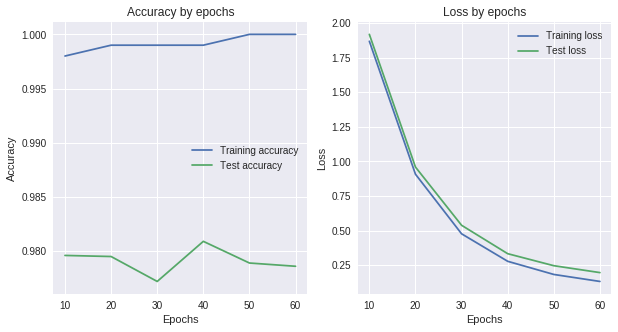

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(xticks, train_acc)
plt.plot(xticks, test_acc)
plt.title('Accuracy by epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Test accuracy'])

plt.subplot(1, 2, 2)
plt.plot(xticks, train_loss)
plt.plot(xticks, test_loss)
plt.title('Loss by epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss', 'Test loss'])

### Store values of weights

In [0]:
weights_val = {}
for w in ['w1', 'w2', 'w3', 'w4', 'w5', 'wout']:
  weights_val[w] = sess.run(weights[w])
  
biases_val = {}
for b in ['b1', 'b2', 'b3', 'b4', 'b5', 'bout']:
  biases_val[b] = sess.run(biases[b])

In [0]:
def compress_matrix(mat, limit=None):
  u, s, vt = np.linalg.svd(mat)

  if limit is None:
    sigma = np.zeros((mat.shape[0], mat.shape[1]))
    sigma[:s.shape[0], :s.shape[0]] = np.diag(s)
    return np.dot(u, np.dot(sigma, vt))    
  
  sigma = np.zeros((limit, limit))
  sigma[:limit, :limit] = np.diag(s[:limit])
  return np.dot(u[:, :limit], np.dot(sigma, vt[:limit, :]))

In [0]:
def run_compressed(sess, limit=None):
  compressed_w1 = compress_matrix(weights_val['w1'], limit)
  sess.run(weights['w1'].assign(compressed_w1))
  
  compressed_w2 = compress_matrix(weights_val['w2'], limit)
  sess.run(weights['w2'].assign(compressed_w2))
  
  compressed_w3 = compress_matrix(weights_val['w3'], limit)
  sess.run(weights['w3'].assign(compressed_w3))
  
  compressed_w4 = compress_matrix(weights_val['w4'], limit)
  sess.run(weights['w4'].assign(compressed_w4))
  
  compressed_w5 = compress_matrix(weights_val['w5'], limit)
  sess.run(weights['w5'].assign(compressed_w5))
  
  tsls, tsac = sess.run([loss, accuracy], feed_dict={X: mnist.test.images, y: mnist.test.labels})
  return tsls, tsac

In [16]:
for limit in [10, 20, 50, 100, 200, None]:
  tsls, tsac = run_compressed(sess, limit)
  print('Limit: {}\tTest loss: {:.5f}\tTest accuracy: {:.5f}'.format(limit, tsls, tsac))

Limit: 10	Test loss: 2.15991	Test accuracy: 0.54960
Limit: 20	Test loss: 1.07082	Test accuracy: 0.76090
Limit: 50	Test loss: 0.35184	Test accuracy: 0.92540
Limit: 100	Test loss: 0.21283	Test accuracy: 0.96930
Limit: 200	Test loss: 0.19788	Test accuracy: 0.97630
Limit: None	Test loss: 0.19702	Test accuracy: 0.97860


In [0]:
def get_components(mat, limit=None):
  u, s, vt = np.linalg.svd(mat)

  if limit is None:
    sigma = np.zeros((mat.shape[0], mat.shape[1]))
    sigma[:s.shape[0], :s.shape[0]] = np.diag(s)
    return u, np.dot(sigma, vt) 
  
  sigma = np.zeros((limit, limit))
  sigma[:limit, :limit] = np.diag(s[:limit])
  return u[:, :limit], np.dot(sigma, vt[:limit, :])

### Assign values calculated by SVD to these layers

In [18]:
limit = 200

w1_u_val, w1_svt_val = get_components(weights_val['w1'], limit)
sess.run(cweights['w1_u'].assign(w1_u_val))
sess.run(cweights['w1_svt'].assign(w1_svt_val))

w2_u_val, w2_svt_val = get_components(weights_val['w2'], limit)
sess.run(cweights['w2_u'].assign(w2_u_val))
sess.run(cweights['w2_svt'].assign(w2_svt_val))

w3_u_val, w3_svt_val = get_components(weights_val['w3'], limit)
sess.run(cweights['w3_u'].assign(w3_u_val))
sess.run(cweights['w3_svt'].assign(w3_svt_val))

w4_u_val, w4_svt_val = get_components(weights_val['w4'], limit)
sess.run(cweights['w4_u'].assign(w4_u_val))
sess.run(cweights['w4_svt'].assign(w4_svt_val))

w5_u_val, w5_svt_val = get_components(weights_val['w5'], limit)
sess.run(cweights['w5_u'].assign(w5_u_val))
sess.run(cweights['w5_svt'].assign(w5_svt_val))


sess.run(cbiases['b1'].assign(biases_val['b1']))
sess.run(cbiases['b2'].assign(biases_val['b2']))
sess.run(cbiases['b3'].assign(biases_val['b3']))
sess.run(cbiases['b4'].assign(biases_val['b4']))
sess.run(cbiases['b5'].assign(biases_val['b5']))

array([ 0.02619826,  0.01762491,  0.0229353 , ...,  0.02150182,
        0.01933078, -0.00104192], dtype=float32)

In [19]:
batch_size = 1000
num_epochs = 60
display_step = 20
log_step = 10

total_samples = mnist.train.images.shape[0]
num_batches = int(math.ceil(total_samples/batch_size))

# these lists will be used to display accuracy/loss graphs over epochs
train_acc, test_acc = [], []
train_loss, test_loss = [], []
xticks = []

sess = tf.Session()
  
for epoch in range(1, num_epochs + 1):
  for itr in range(num_batches):
    batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
    sess.run(ctrain, feed_dict={cX: batch_x, cy: batch_y})
    
  if epoch % log_step == 0:
    trls, trac = sess.run([closs, caccuracy], feed_dict={cX: batch_x, cy: batch_y})
    tsls, tsac = sess.run([closs, caccuracy], feed_dict={cX: mnist.test.images, cy: mnist.test.labels})
    
    train_acc.append(trac)
    test_acc.append(tsac)
    train_loss.append(trls)
    test_loss.append(tsls)
    xticks.append(epoch)
    
  if epoch % display_step == 0:
    print(f'Epoch:{epoch}')
    print(f'Train set:\tLoss:{trls:.4f},\tAccuracy:{trac:.4f}')
    print(f'Test set:\tLoss:{tsls:.4f},\tAccuracy:{tsac:.4f}\n')

FailedPreconditionError: ignored

## Analyze weight distribution

In [0]:
def plot_weight_distribution(weights):
  len_wt = len(weights)
  
  plt.figure(figsize=(5 * len_wt, 5))
  for idx, (key, w_op) in enumerate(weights.items()):
    w_val = sess.run(w_op)
    plt.subplot(1, len_wt, idx + 1)
    plt.title(key)
    plt.hist(w_val.reshape(-1), bins=50)

In [0]:
plot_weight_distribution(weights)

## Visualize network output

### Pass 1000 test samples through network. For each digit find images that neural network associates with that digit. Plot 10 such images for each digit

In [0]:
# pass 1000 images through trained model and get 10 images per output class giving maximum softmax activation
batch_x, batch_y = mnist.test.next_batch(1000)
a1_val, a2_val, a3_val, a4_val, a5_val, output_val = sess.run([a1, a2, a3, a4, a5, output], feed_dict={X:batch_x, y:batch_y})

## Visualize data in reduced dimensions (Principal Components)

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Feed some data to neural network to get activation at each layer

In [0]:
num_samples = 5000
subset_x = mnist.train.images[:num_samples]
subset_y_one_hot = mnist.train.labels[:num_samples];
subset_y = np.argmax(subset_y_one_hot, axis=1)

In [0]:
a1_val, a2_val, a3_val, a4_val, a5_val, logits_val, output_val = sess.run([a1, a2, a3, a4, a5, logits, output], feed_dict={X: subset_x, y: subset_y_one_hot})

### Helper function to plot 2 main components given by tSNE

In [0]:
def plot_tsne(ax, x, y, title):
  model = TSNE(learning_rate=100)
  transformed = model.fit_transform(x)
  tx = transformed[:, 0]
  ty = transformed[:, 1]
  ax.scatter(tx, ty, c=y, cmap='plasma', s=10)
  ax.set_title(title)
  for d in range(10):
    cx, cy = np.mean(transformed[y == d], axis=0)
    plt.text(cx, cy, str(d), fontsize=50, color='k', weight='bold')

### Helper function to plot 2 main components given by PCA

In [0]:
def plot_pca(ax, x, y, title):
  model = PCA(n_components=2)
  transformed = model.fit_transform(x)
  tx = transformed[:, 0]
  ty = transformed[:, 1]
  ax.scatter(tx, ty, c=y, cmap='plasma', s=10)
  ax.set_title(title)
  for d in range(10):
    cx, cy = np.mean(transformed[y == d], axis=0)
    plt.text(cx, cy, str(d), fontsize=50, color='k', weight='bold')

### Components of raw input

In [0]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plot_pca(ax, subset_x, subset_y, 'PCA on Input')

ax = plt.subplot(1, 2, 2)
plot_tsne(ax, subset_x, subset_y, 'tSNE on Input')

### Principal Components  of output layer (logits)

In [0]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plot_pca(ax, logits_val, subset_y, 'PCA on output layer (logits)')

ax = plt.subplot(1, 2, 2)
plot_tsne(ax, logits_val, subset_y, 'tSNE on output layer (logits)')

### Principal Components of softmax layer

In [0]:
plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
plot_pca(ax, output_val, subset_y, 'PCA on 3rd softmax layer')

ax = plt.subplot(1, 2, 2)
plot_tsne(ax, output_val, subset_y, 'tSNE on 3rd softmax layer')

By looking at above graphs,

1. The raw data samples are not separable at all as they overlap with each other.

2. The activations of first hidden layer are also not separable, but little better than raw data. The data points of each class seem to form a cluster. This is because of the extra non-linear features added by the first layer.

3. As we go deeper down the network, more complex features are evolved which makes the data more and more separable. 

We can think of this as follows,

Each layer is a matrix. Multiplying such matrix to input data, transforms the input space into some high dimensional space. (increase from 784 to 1024). The non-linearity sees that the relative positions of data points change in the transformed space. (Simple matrix multiplication can only make input space squeeze, expand or skew).

The 2nd layer does the same thing but starting with already transformed space. So the resulting space is even more complex. And so does the other layers.

Now these transformations would be useful if the input data is a little more separable in the transformed space. That's exactly what the backpropogation takes care of. 

Some of the above intuition comes of this video [Linear transformations and matrices - 3blue1Brown](https://www.youtube.com/watch?v=kYB8IZa5AuE)

In [0]:
sess.close()